In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
from IPython.display import display, Math
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()

In [2]:
params = {'period@binary': 30.,
't0_supconj': 1.23,
'mass@primary': 3.2,
'mass@secondary': 0.93,
'requiv@primary': 2.5,
'requiv@secondary': 0.93,
'teff@primary': 10800,
'irrad_frac_refl_bol@primary': 1,
'gravb_bol@primary': 1,
'teff@secondary': 5610,
'incl@binary': 89.751,
'ecc': 0.32,
'per0': 86,
'pblum': 15.024,
'l3': 0.0}

In [3]:
np.random.seed(3)
times = np.random.uniform(0.0, 150, 1000)
times.sort()

In [4]:
b = phoebe.default_binary(force_build=True)
b.add_dataset('lc', times = times)
b.flip_constraint('mass@secondary', solve_for='q')
b.flip_constraint('mass@primary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = (((({mass@primary@component} * ({period@binary@component} ** 2.000000)) * (1.000000 + {q@binary@component})) * 2942.206217504419328179210424423218) / 39.478418) ** (1./3) (solar units) => 5.299999999999999 solRad>

In [5]:
for twig in params.keys():
    b[twig] = params[twig]
b.run_delayed_constraints()
b.run_checks()

<RunChecksReport 1 items: status=WARNING>

In [6]:
b.add_compute('ellc', compute='ellcbnd')
b.set_value_all('ld_mode*', 'lookup')
b.run_compute(compute='ellcbnd')

100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


<ParameterSet: 3 parameters | qualifiers: fluxes, times, comments>

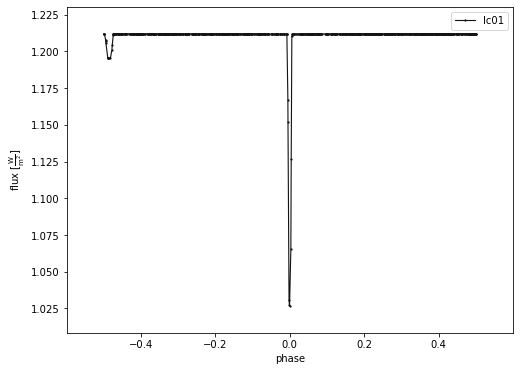

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [11]:
%matplotlib inline
b.plot(x='phase', s=0.01,  marker='.', legend=True, show=True)

In [9]:
times = b['value@times@model']
# add small gaussian noise to the fluxes
sigma = 0.001
np.random.seed(2)
fluxes = b['value@fluxes@model'] + np.random.normal(0,sigma,len(times))
sigmas = np.full_like(fluxes, sigma)
np.savetxt('data/d_we.lc', np.array([times, fluxes, sigmas]).T)

In [10]:
b.save('data/d_we.bundle')

'data/d_we.bundle'

# OPTIMIZE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
from IPython.display import display, Math
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()

from optimize_funcs import *

## Nelder-Mead

In [2]:
label = 'd_we'
b, b_true = setup_bundle(label)

In [3]:
ecc = 0.2753709681902242
per0 = 1.4824337277607507
esinw = ecc*np.sin(per0)
ecosw = ecc*np.cos(per0)

100%|██████████| 1/1 [00:00<00:00, 14.87it/s]


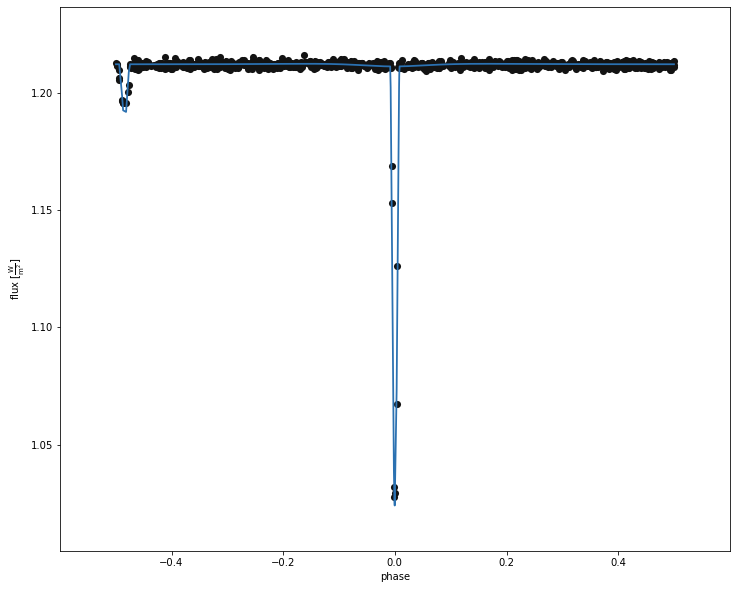

In [4]:
b = update_vals(b, 
                ['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'], 
                [87., 0.85, 0.07885319, 0.45, esinw, ecosw],
               'ellcbnd')

In [5]:
b.save('data/%s_manual.bundle' % label)

'data/d_we_manual.bundle'

### optimize full

In [6]:
label = 'we_nm'
b = phoebe.load('data/d_we_manual.bundle')

365940it [18:38, 745.43it/s]                      
100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


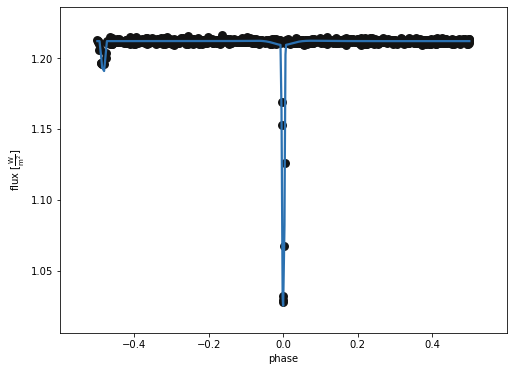

In [7]:
b=optimize_params(b, ['incl@binary', 'teffratio', 'requivratio', 'requivsumfrac', 'esinw', 'ecosw'], 'full', 'ellcbnd', optimizer='nm',  plot=True)

In [8]:
b.save('data/%s_full.bundle' % label)

'data/we_nm_full.bundle'

### sequential

In [9]:
b = phoebe.load('data/d_we_manual.bundle')

In [10]:
%matplotlib qt
b.add_solver('estimator.lc_geometry', solver='est_lcgeom', phase_bin=False, fit_eclipses=True, interactive=False)
b.run_solver('est_lcgeom', solution='lcgeom_sol')

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9953: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


<ParameterSet: 22 parameters | qualifiers: fitted_values, analytic_best_model, analytic_fluxes, secondary_phase, primary_depth, secondary_width, adopt_parameters, secondary_depth, adopt_distributions, orbit, adopt_values, fitted_units, input_phases, primary_phase, fitted_uniqueids, input_sigmas, eclipse_edges, fitted_twigs, input_fluxes, comments, analytic_phases, primary_width>

In [11]:
b['mask_phases'] = b['value@fitted_values@lcgeom_sol'][-1]

In [12]:
%matplotlib inline


  1%|          | 6/1000 [00:05<26:32,  1.60s/it]
365940it [18:49, 745.43it/s]:06<20:05,  1.22s/it]
  4%|▎         | 36/1000 [00:11<07:02,  2.28it/s]
365940it [18:56, 322.06it/s]:13<05:34,  2.86it/s]

 99%|█████████▉| 990/1000 [00:59<00:00, 34.67it/s]
1035it [01:01, 26.79it/s]                         
1081it [01:03, 28.59it/s]
1128it [01:05, 24.36it/s]
1176it [01:08, 22.08it/s]
1225it [01:09, 27.99it/s]
1275it [01:09, 34.57it/s]
1326it [01:11, 35.78it/s]
1378it [01:13, 28.85it/s]
1431it [01:14, 35.76it/s]
1485it [01:15, 42.47it/s]
1540it [01:17, 32.56it/s]
1596it [01:20, 27.73it/s]
1653it [01:21, 30.84it/s]
1711it [01:24, 27.48it/s]
1770it [01:25, 31.15it/s]
1830it [01:27, 34.27it/s]
1891it [01:29, 30.19it/s]
1953it [01:31, 34.01it/s]
2016it [01:33, 30.35it/s]
2080it [01:34, 34.25it/s]
2145it [01:37, 31.00it/s]
2211it [01:40, 29.07it/s]
2278it [01:41, 33.15it/s]
2346it [01:44, 30.71it/s]
2415it [01:44, 38.01it/s]
2485it [01:47, 31.99it/s]
2556it [01:50, 29.51it/s]
2628it [01:51, 37.41i

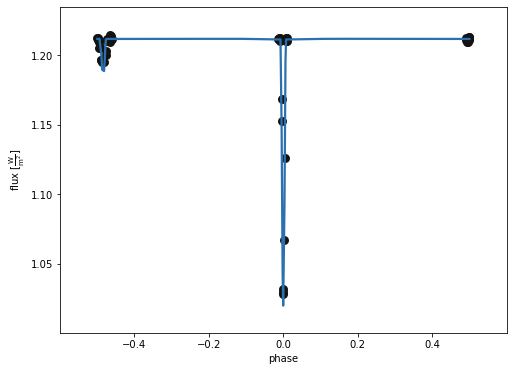

In [13]:
b = optimize_params(b, ['requivsumfrac','incl@binary'], 'rsumincl', 'ellcbnd',optimizer='nm', plot=True)

  2%|▏         | 21/1000 [00:08<09:45,  1.67it/s]
4656it [02:49, 27.45it/s][00:11<04:26,  3.58it/s]
4465it [02:12, 56.21it/s]                         
100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


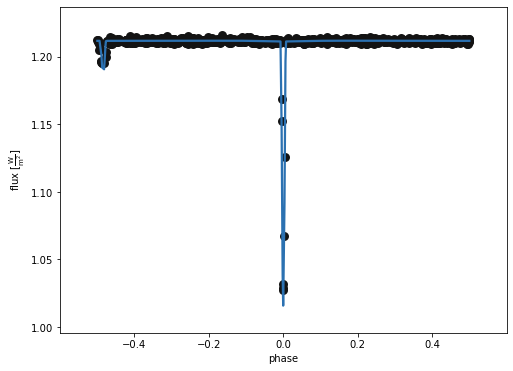

In [14]:
b['mask_phases'] = []
b = optimize_params(b, ['teffratio', 'esinw'], 'teffresw', 'ellcbnd', optimizer='nm', plot=True)


4465it [02:14, 33.09it/s]00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 10.77it/s]it/s]


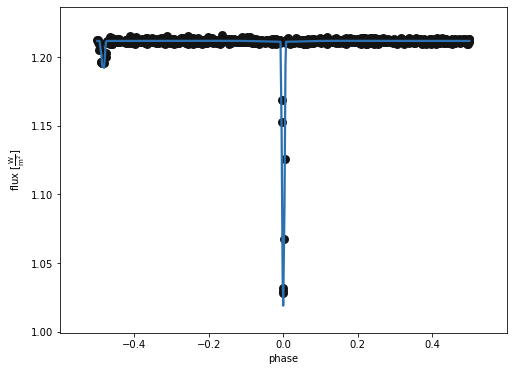

In [15]:
b = optimize_params(b, ['requivsumfrac', 'requivratio', 'teffratio'], 'rsumrrteffr', 'ellcbnd', optimizer='nm', plot=True)

 99%|█████████▉| 990/1000 [00:50<00:00, 19.73it/s]
190653it [13:32, 409.40it/s]                      
100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


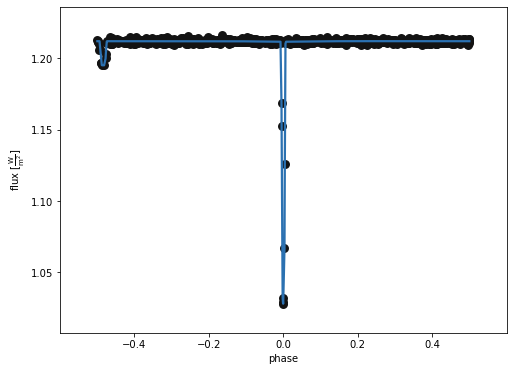

In [16]:
b = optimize_params(b, ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw'], 'all', 'ellcbnd', optimizer='nm', plot=True)

In [17]:
b.save('data/%s_seq.bundle' % label)

'data/we_nm_seq.bundle'

### grid search --> optimize

In [18]:
!scp angela@terra.villanova.edu:fitting/phoetting_paper/cases/AAS_poster/data/wide_eccentric_manual_finegrid data/

wide_eccentric_manual_finegrid                100% 6455KB   2.5MB/s   00:02    


In [19]:
gs_results = np.loadtxt('data/wide_eccentric_manual_finegrid')
fit_params = ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw']
gs_results_filter = gs_results[gs_results[:,-1] != -np.inf]
minres = gs_results_filter[np.nanargmin(gs_results_filter[:,-1])]

In [20]:
b = phoebe.load('data/d_we_manual.bundle')


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


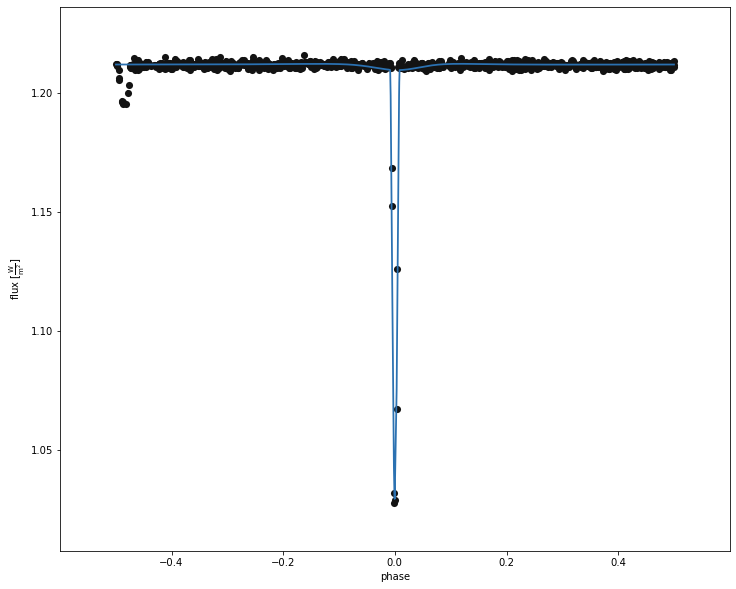

In [21]:
b = update_vals(b, 
                ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw'], 
                minres[:-1],
               'ellcbnd')


190653it [13:44, 409.40it/s]00<?, ?it/s]
  6%|▌         | 55/1000 [00:17<05:48,  2.71it/s]
190653it [14:01, 226.45it/s]:19<04:54,  3.17it/s]

 99%|█████████▉| 990/1000 [01:06<00:00, 25.66it/s]
1035it [01:07, 26.13it/s]                         
1081it [01:09, 26.66it/s]
1128it [01:11, 27.09it/s]
1176it [01:12, 27.68it/s]
1225it [01:14, 28.18it/s]
1275it [01:15, 33.44it/s]
1326it [01:16, 38.27it/s]
1378it [01:17, 36.06it/s]
1431it [01:19, 34.94it/s]
1485it [01:21, 34.35it/s]
1540it [01:21, 39.89it/s]
1596it [01:23, 35.80it/s]
1653it [01:25, 33.97it/s]
1711it [01:27, 32.69it/s]
1770it [01:28, 38.50it/s]
1830it [01:30, 37.78it/s]
1891it [01:32, 36.00it/s]
1953it [01:34, 35.31it/s]
2016it [01:35, 36.24it/s]
2080it [01:37, 36.69it/s]
2145it [01:38, 43.42it/s]
2211it [01:39, 49.58it/s]
2278it [01:40, 46.96it/s]
2346it [01:42, 44.62it/s]
2415it [01:44, 42.89it/s]
2485it [01:44, 50.59it/s]
2556it [01:46, 47.35it/s]
2628it [01:47, 54.26it/s]
2701it [01:49, 50.49it/s]
2775it [01:50, 57.74it/s]
2

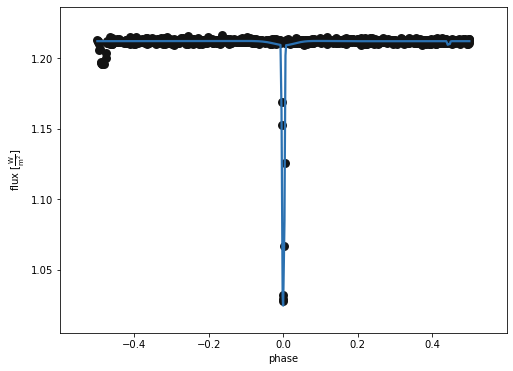

In [22]:
b = optimize_params(b, fit_params, 'after_gs', 'ellcbnd', optimizer='nm', plot=True)

In [23]:
b.save('data/%s_gs.bundle' % label)

'data/we_nm_gs.bundle'

## conjugate gradient

### optimize full

In [24]:
label = 'we_cg'
b = phoebe.load('data/d_we_manual.bundle')

  0%|          | 0/1000 [00:00<?, ?it/s]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
169653it [16:06, 175.49it/s]
100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


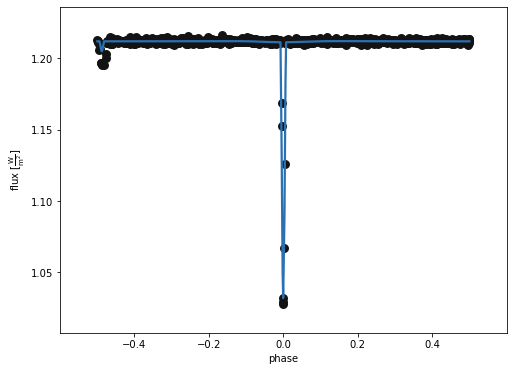

In [25]:
b=optimize_params(b, ['incl@binary', 'teffratio', 'requivratio', 'requivsumfrac', 'esinw', 'ecosw'], 'full', 'ellcbnd', optimizer='cg',  plot=True)

In [26]:
b.save('data/%s_full.bundle' % label)

'data/we_cg_full.bundle'

### sequential

In [27]:
b = phoebe.load('data/d_we_manual.bundle')

In [28]:
%matplotlib qt
b.add_solver('estimator.lc_geometry', solver='est_lcgeom', phase_bin=False, fit_eclipses=True, interactive=False)
b.run_solver('est_lcgeom', solution='lcgeom_sol')

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9953: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


<ParameterSet: 22 parameters | qualifiers: fitted_values, analytic_best_model, analytic_fluxes, secondary_phase, primary_depth, secondary_width, adopt_parameters, secondary_depth, adopt_distributions, orbit, adopt_values, fitted_units, input_phases, primary_phase, fitted_uniqueids, input_sigmas, eclipse_edges, fitted_twigs, input_fluxes, comments, analytic_phases, primary_width>

In [29]:
b['mask_phases'] = b['value@fitted_values@lcgeom_sol'][-1]

In [30]:
%matplotlib inline


 30%|███       | 300/1000 [08:39<20:11,  1.73s/it]
/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0

  0%|          | 1/1000 [00:07<2:00:55,  7.26s/it]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


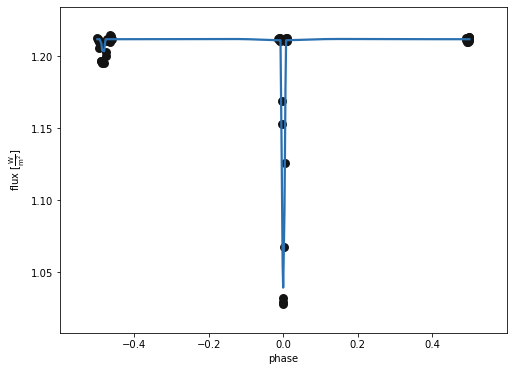

In [31]:
b = optimize_params(b, ['requivsumfrac','incl@binary'], 'rsumincl', 'ellcbnd',optimizer='cg', plot=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  0%|          | 1/1000 [00:37<10:24:11, 37.49s/it]

100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


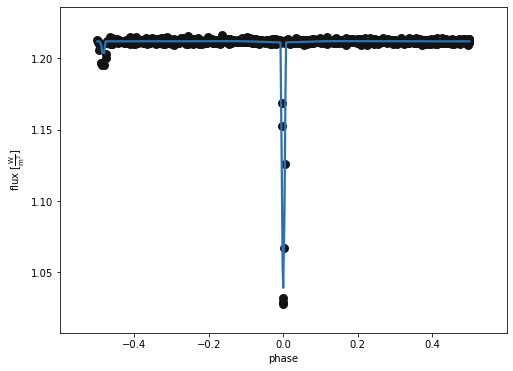

In [32]:
b['mask_phases'] = []
b = optimize_params(b, ['teffratio', 'esinw'], 'teffresw', 'ellcbnd', optimizer='cg', plot=True)


  0%|          | 0/1000 [00:00<?, ?it/s]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  0%|          | 0/1000 [00:27<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.46it/s]     


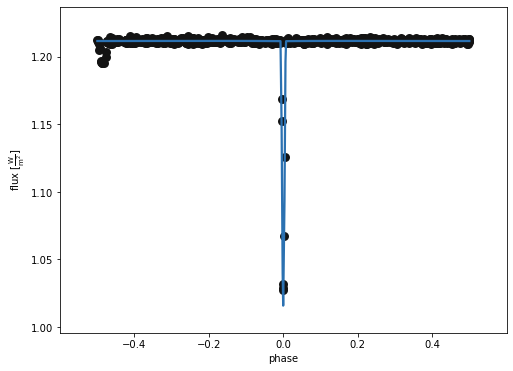

In [33]:
b = optimize_params(b, ['requivsumfrac', 'requivratio', 'teffratio'], 'rsumrrteffr', 'ellcbnd', optimizer='cg', plot=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
1035it [06:35,  2.62it/s]
100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


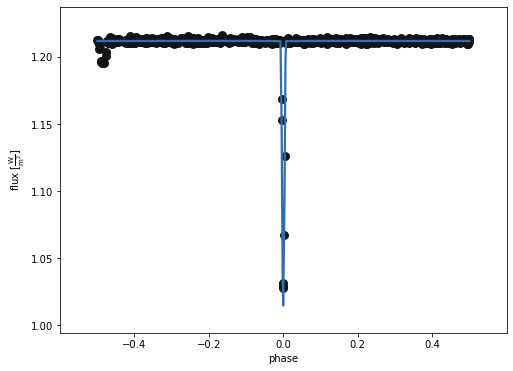

In [34]:
b = optimize_params(b, ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw'], 'all', 'ellcbnd', optimizer='cg', plot=True)

In [35]:
b.save('data/%s_seq.bundle' % label)

'data/we_cg_seq.bundle'

### grid search --> optimize

In [36]:
gs_results = np.loadtxt('data/wide_eccentric_manual_finegrid')
fit_params = ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw']
gs_results_filter = gs_results[gs_results[:,-1] != -np.inf]
minres = gs_results_filter[np.nanargmin(gs_results_filter[:,-1])]

In [37]:
b = phoebe.load('data/d_we_manual.bundle')


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


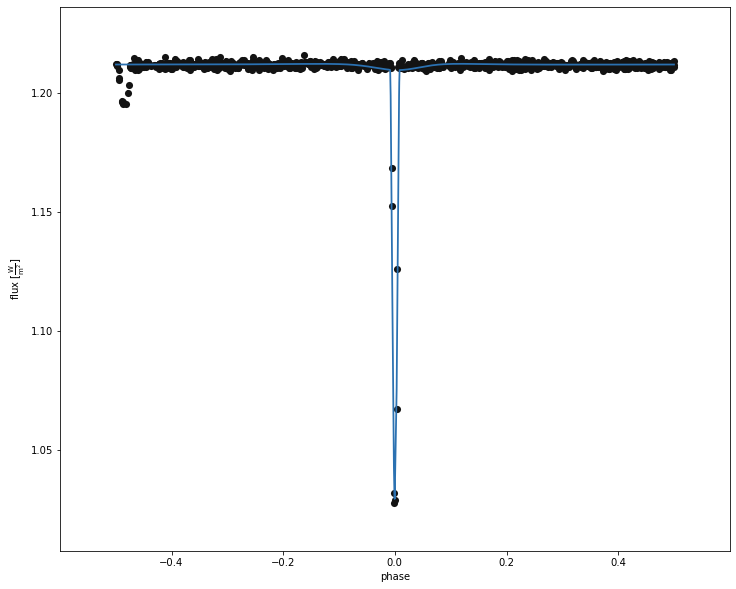

In [38]:
b = update_vals(b, 
                ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw'], 
                minres[:-1],
               'ellcbnd')


  0%|          | 0/1000 [00:00<?, ?it/s]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  1%|          | 6/1000 [02:45<7:37:01, 27.59s/it]

  0%|          | 1/1000 [00:17<4:50:34, 17.45s/it]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0

100%|██████████| 1/1 [00:00<00:00,  9.63it/s]0s/it]


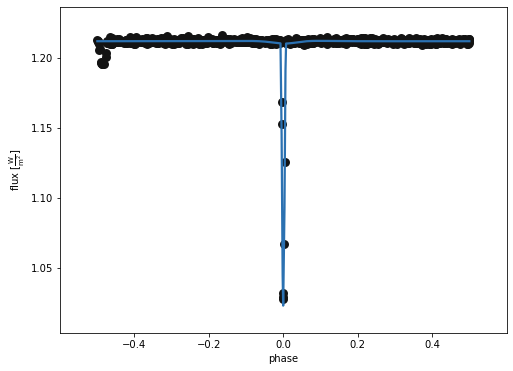

In [39]:
b = optimize_params(b, fit_params, 'after_gs', 'ellcbnd', optimizer='cg', plot=True)

In [40]:
b.save('data/%s_gs.bundle' % label)

'data/we_cg_gs.bundle'

# MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
from optimize_funcs import *

### initialize from good result

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9953: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)
100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


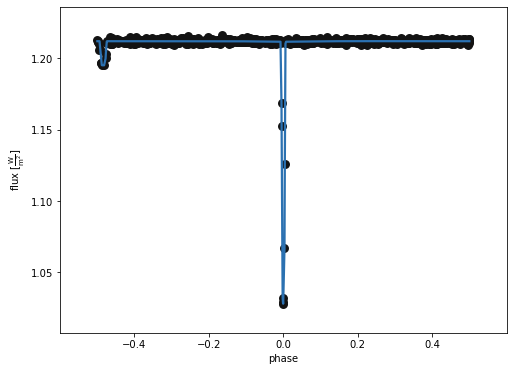

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [2]:
b = phoebe.load('data/we_nm_seq.bundle')
b.run_compute(compute='ellcbnd', model='latest')
b.plot(['dataset', 'latest'], x='phase',show=True)

In [3]:
params0 = np.array(['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'])
priors0 = np.array([[50,90], [0.01,10], [0.0001, 1.], [0.1,10], [-1,1], [-1,1]])

params_teff1_sma_q_p_t0 = np.array(['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw', 
                                'teff@primary',
                                'sma@binary', 'q',
                                'period@binary', 't0_supconj'])
priors_teff1_sma_q_p_t0 = np.array([[50,90], [0.01,10], [0.0001, 1.], [0.1,10], [-1,1], [-1,1], 
                        [3500,20000],
                        [5,50], [0.1,10],
                        [np.nan,np.nan], [np.nan,np.nan]])

In [4]:
b=add_dist_solver_export(b, params0, priors0, 'we_goodinit', '0')
b=add_dist_solver_export(b, params_teff1_sma_q_p_t0, priors_teff1_sma_q_p_t0, 'we_goodinit', 'teff1_sma_q_p_t0')

In [7]:
b.save('data/we_goodinit_dists.bundle')

'data/close_eccentric_manual2seq_dists.bundle'

### initialize from bad result

100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


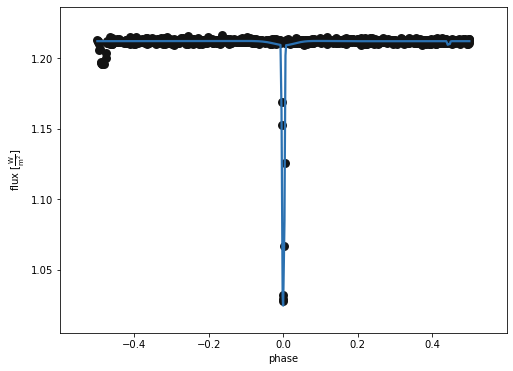

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [6]:
b = phoebe.load('data/we_nm_gs.bundle')
b.run_compute(compute='ellcbnd', model='latest')
b.plot(['dataset', 'latest'], x='phase',show=True)

In [7]:
params0 = np.array(['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'])
priors0 = np.array([[50,90], [0.01,10], [0.0001, 1.], [0.1,10], [-1,1], [-1,1]])

params_teff1_sma_q_p_t0 = np.array(['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw', 
                                'teff@primary',
                                'sma@binary', 'q',
                                'period@binary', 't0_supconj'])
priors_teff1_sma_q_p_t0 = np.array([[50,90], [0.01,10], [0.0001, 1.], [0.1,10], [-1,1], [-1,1], 
                        [3500,20000],
                        [5,50], [0.1,10],
                        [np.nan,np.nan], [np.nan,np.nan]])

In [8]:
b=add_dist_solver_export(b, params0, priors0, 'we_badinit', '0')
b=add_dist_solver_export(b, params_teff1_sma_q_p_t0, priors_teff1_sma_q_p_t0, 'we_badinit', 'teff1_sma_q_p_t0')

In [9]:
b.save('data/we_badinit_dists.bundle')

'data/we_badinit_dists.bundle'